# Parameter Test

Calls AlphaPept for a parameter range and checks performance.

In [1]:
from time import time
%load_ext autoreload
%autoreload 2

import logging

## Parameter Test

In [2]:
import os

test_dir = './integration_test/'

files = os.listdir('./integration_test/')

raw_files = None
fasta_file = None

for file in files:
    base, ext = os.path.splitext(file)
    
    if ext == '.fasta':
        fasta_file = os.path.abspath(os.path.join(test_dir, file))
        print('Found fasta file: {}'.format(fasta_file))
    elif ext == '.raw':
        if not raw_files:
            raw_files = []
            raw_files.append(os.path.abspath(os.path.join(test_dir, file)))
        else:
            raw_files.append(os.path.abspath(os.path.join(test_dir, file)))
        print('Found thermo file: {}'.format(file))
    elif ext == '.d':
        if not raw_files:
            raw_files = []
            raw_files.append(os.path.abspath(os.path.join(test_dir, file)))
        else:
            raw_files.append(os.path.abspath(os.path.join(test_dir, file)))
        print('Found bruker file: {}'.format(file))
    else:
        print('File not recognized: {}'.format(file))
        
        
#Todo: Later combine files that might belong together (i.e. in folder, or of same type)

File not recognized: 20190402_QX1_SeVW_MA_HeLa_500ng_LC11.npz
Found thermo file: 20190402_QX1_SeVW_MA_HeLa_500ng_LC11.raw
File not recognized: 20190402_QX1_SeVW_MA_HeLa_500ng_LC11_ap.csv
File not recognized: 20190402_QX1_SeVW_MA_HeLa_500ng_LC11_ap.yaml
Found bruker file: 20191209_TIMS05_QC_ADB_AfterSRIGUpgrade_200ng_03_A1_1_1428.d
File not recognized: 20191209_TIMS05_QC_ADB_AfterSRIGUpgrade_200ng_03_A1_1_1428.npz
File not recognized: 20191209_TIMS05_QC_ADB_AfterSRIGUpgrade_200ng_03_A1_1_1428_ap.csv
File not recognized: 20191209_TIMS05_QC_ADB_AfterSRIGUpgrade_200ng_03_A1_1_1428_ap.yaml
Found fasta file: F:\projects\alphapept\integration_test\uniprot_Human_reviewed_March_2019_manual.fasta
File not recognized: uniprot_Human_reviewed_March_2019_manual.npz


In [3]:
from alphapept.settings import load_settings

settings_template = load_settings('settings_template.yaml')


In [4]:
param_group = 'search'
param_key = 'm_tol'

minval = settings_template[param_group][param_key]['min']
maxval = settings_template[param_group][param_key]['max']

In [5]:
from alphapept.settings import load_settings

default_settings = load_settings('default_settings.yaml')

# Deactivate maxlfq and match between runs in the default case as they are not implemented
# Also deactivete library creation
# Otherwise: Activate all functions and deactivate to test

default_settings['quantification']['max_lfq'] = False
default_settings['misc']['match_between_runs'] = False
default_settings['general']['create_library'] = False
default_settings['general']['find_features'] = False
default_settings['raw']['convert_raw'] = False

#Fill with paths from above 
default_settings['fasta']['fasta_path'] = 'F:/projects/alphapept/integration_test/uniprot_Human_reviewed_March_2019_manual.fasta'
default_settings['fasta']['contaminants_path'] = 'F:/projects/alphapept/contaminants.fasta'
default_settings['fasta']['library_path'] =  'F:/projects/alphapept/integration_test/uniprot_Human_reviewed_March_2019_manual.npz'


In [6]:
import copy 
from tqdm.notebook import tqdm as tqdm
import numpy as np

n_checks = 30

test_cases = []

for point in np.linspace(10, maxval, n_checks): #todo: Change minval to get 0 psms
    for file in raw_files:        
        test_case = copy.deepcopy(default_settings)

        test_case['raw']['raw_path'] = file
        base, ext = os.path.splitext(file)
        test_case['raw']['raw_path_npz'] = base + '.npz'
        test_case[param_group][param_key] = point

        test_cases.append(test_case)

In [7]:
from time import time
import numpy as np
from alphapept.runner import alpha_runner

def run_test(settings):
    """
    Run a test with certain settings
    """
    
    def dummy_status(var):
        pass

    start = time()
    
    try:
        df, features = alpha_runner(settings, CURRENT_TASK = dummy_status)
        error = False
    except Exception as e:
        print('Experienced the following exception:')
        print('-'*100)
        print(e)
        print('-'*100)
        df = None
        error = True

    end = time()
            
            
    if df is not None:
        n_proteins = len(set(df['protein']))
        n_sequences = len(set(df['sequence']))
        n_sequence_charges = len(set(df['sequence'] + df['charge'].astype('int').astype('str')))
    else:
        n_proteins = np.nan
        n_sequences = np.nan
        n_sequence_charges = np.nan      
    
    time_minutes = (end-start)/60
    
    return (n_proteins, n_sequences, n_sequence_charges, time_minutes, error)

In [8]:
if False:
    import pandas as pd
    from tqdm.notebook import tqdm as tqdm

    report = []
    start = time()
    for test_case in tqdm(test_cases):
        filepath = test_case["raw"]["raw_path_npz"]
        filename = os.path.split(filepath)[-1]
        report.append(tuple([filename, test_case[param_group][param_key]]) + run_test(test_case))

    end = time()

    import pandas as pd

    print('Integration test complete. Time elapsed {:.2f} hours'.format((end-start)/60/60))

    columns = ['filename', 'value', 'n_proteins', 'n_sequences', 'n_sequence_charges', 'time_minutes', 'error']

    rep = pd.DataFrame(report, columns = columns)

    print('Complete')


Integration test complete. Time elapsed 3.11 hours
Complete


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

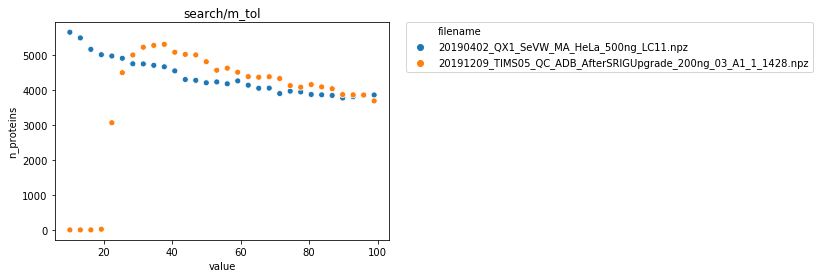

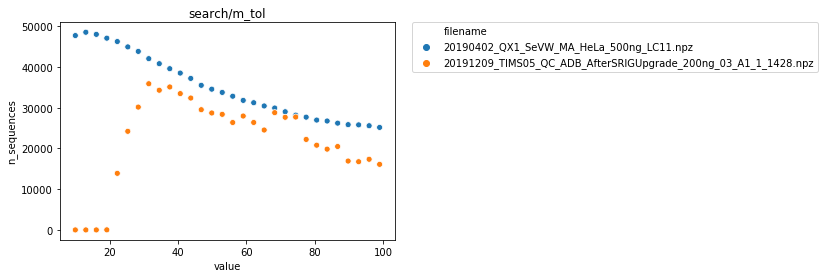

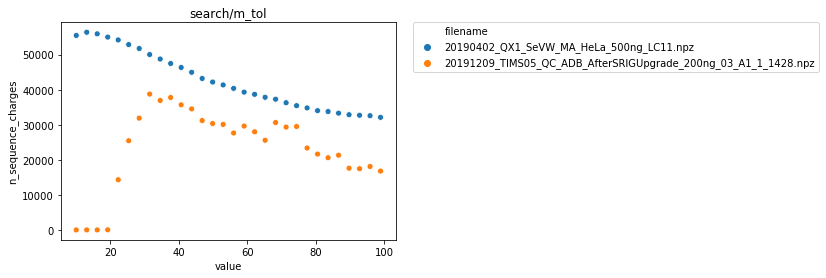

In [10]:
plt.figure()
sns.scatterplot(y='n_proteins', x = 'value', hue = 'filename', data = rep)
plt.title(param_group + '/' + param_key)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.figure()
sns.scatterplot(y='n_sequences', x = 'value', hue = 'filename', data = rep)
plt.title(param_group + '/' + param_key)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.figure()
sns.scatterplot(y='n_sequence_charges', x = 'value', hue = 'filename', data = rep)
plt.title(param_group + '/' + param_key)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()